# 02 - Preprocess

In this notebook we will take the samples images from [01 - Take Samples](01_take_samples.ipynb) and do some preprocessing.

More specifically, we will resize the images and create a copy of them in both color and in grayscale. More details will be provided as we go.

## Imports

In [1]:
import pandas as pd
import numpy as np
import imageio
from skimage.transform import resize
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

from funcs.preprocessing import read_data, resize_images, to_gray
from funcs.plot import show_image

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

In [4]:
train_val_images, train_val_annotations = read_data()

In [5]:
train_val_images.head()

,file_name,width,height,id,level,n_pixels,source
0,data/retail_product/val2019/20180831-13-59-15-...,1802,1802,7388,easy,3247204,train
1,data/retail_product/val2019/20181011-17-10-30-...,1840,1840,11456,medium,3385600,train
2,data/retail_product/val2019/20181016-16-45-20-...,1831,1831,13038,medium,3352561,train
3,data/retail_product/val2019/20180905-15-26-26-...,1832,1832,19004,medium,3356224,train
4,data/retail_product/val2019/20180906-17-15-21-...,1792,1792,19043,medium,3211264,train


## Resizing

Since the main idea of the project relies on taking non-overlapping patches of the images and detecting wheter there is a glance of an object there, we need to consistently take *n* number of patches of any images to fit and later predict with the model.

However, as seen previously, our collection of images are all square, but with diverging sizes. Hence, a unique patch size might leave out some parts of the image. For example:

* Let's take image id 7388, sampled as a train image. It is sized as 1802x1802, leading to $1802^2 = 3247204$ pixels

    A patch size of 200 will produce $3247204/(200^2) ~= 81.18$ patches. Therefore, to fit a equal number of patches we would have to either pad or crop the image. The first adding unnecessary noise while the second might leave information out.

Since we are in a situation where we some loss of information seems inevitable, might be easier to just downsize the images, as to somewhat keeps its integrity. This has some benefits:

1. For a image in a power of 2, we can try a wide range of patch sizes that are also a power of 2, such as 64, 16, 8... Each with its own pros and cons, but all will always give patches that cover the whole image
2. Lower memory usage which can lead to the use of more images

Therefore, for now, we will resize the images as little as possible, rescaling them to be 1024x1024

In [6]:
train_val_images.iloc[[0]]

,file_name,width,height,id,level,n_pixels,source
0,data/retail_product/val2019/20180831-13-59-15-...,1802,1802,7388,easy,3247204,train


We will resize the images using `skimage resize` function, which actually downscales the images using a gaussian filter. Let's see an example. 

In [7]:
original_img = imageio.imread(train_val_images.iloc[0, 0]) # taking the filename and reading the image

resized_img = resize(original_img, (1024, 1024), preserve_range=True).astype(np.uint8)

Seems that the resized image is a little shifted to the left, but otherwise it looks fine

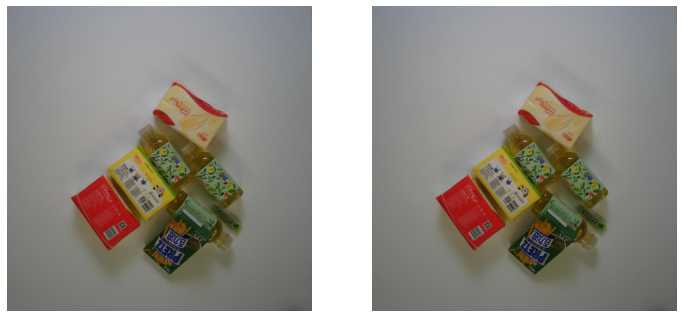

In [8]:
fig, axs = plt.subplots(ncols=2)

for img, ax in zip([original_img, resized_img], axs):

    ax.imshow(img)
    ax.axis('off')


plt.show()

We will use a function to resize all images and store them on a new folder, with new names. Moreover, we will also create an updated dataframe to hold the information

In [9]:
resized_train_val_images = resize_images(train_val_images, 1024)

## Converting to grayscale

We can also test if we can find the objects in grayscale. Similar to resizing the images, we will use a function from `skimage` called `rgb2gray`.

Let's see an example

In [10]:
gray_image = rgb2gray(resized_img)

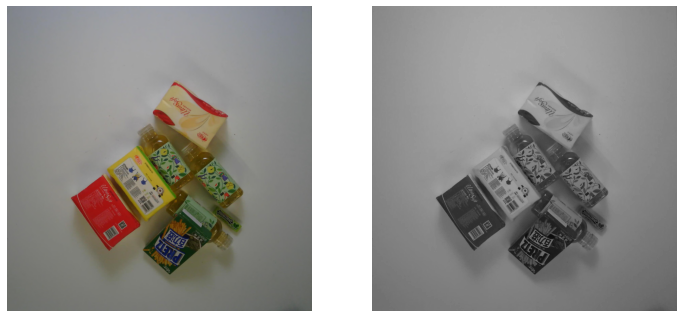

In [11]:
fig, axs = plt.subplots(ncols=2)

axs[0].imshow(resized_img)
axs[0].axis('off')

axs[1].imshow(gray_image, cmap='gray')
axs[1].axis('off')

plt.show()

Similarly, we can use a function to create a copy of our images in grayscale, and also create a new dataframe to hold their paths.

In [12]:
gray_train_val_images = to_gray(resized_train_val_images)

## Rescaling the annotations

As we rescaled the images, we also have to make changes to rescale the annotations from the bounding boxes

In [15]:
resized_train_val_annotations = train_val_annotations.copy()
resized_train_val_annotations = resized_train_val_annotations.merge(resized_train_val_images[['id', 'width_ratio', 'height_ratio']], left_on='image_id', right_on='id')

In [19]:
resized_train_val_annotations['bbox'] = resized_train_val_annotations.apply(lambda x: [round(x['bbox'][i]*x['width_ratio'], 2) if i%2==0 else round(x['bbox'][i]*x['width_ratio'], 2) for i in range(len(x['bbox']))], axis=1)
resized_train_val_annotations['point_xy'] = resized_train_val_annotations.apply(lambda x: [round(x['point_xy'][0]*x['width_ratio'], 2), round(x['point_xy'][1]*x['width_ratio'], 2)], axis=1)

In [20]:
train_val_annotations.head()

,area,bbox,category_id,id,image_id,iscrowd,segmentation,point_xy
316,62966.28,"[1017.12, 1037.5, 360.29, 174.77]",131,2203,583,0,[[]],"[1197.27, 1124.88]"
317,175741.49,"[519.71, 974.93, 384.49, 457.08]",64,2204,583,0,[[]],"[711.96, 1203.47]"
318,164760.36,"[226.64, 837.56, 287.69, 572.7]",170,2205,583,0,[[]],"[370.49, 1123.91]"
319,174151.07,"[503.57, 429.85, 392.55, 443.64]",64,2206,583,0,[[]],"[699.85, 651.67]"
523,112336.58,"[793.98, 370.29, 184.04, 610.38]",75,2852,729,0,[[]],"[886.0, 675.48]"


In [21]:
resized_train_val_annotations.head()

,area,bbox,category_id,id_x,image_id,iscrowd,segmentation,point_xy,id_y,width_ratio,height_ratio
0,62966.28,"[568.83, 580.23, 201.49, 97.74]",131,2203,583,0,[[]],"[669.58, 629.1]",583,0.559257,0.559257
1,175741.49,"[290.65, 545.24, 215.03, 255.63]",64,2204,583,0,[[]],"[398.17, 673.05]",583,0.559257,0.559257
2,164760.36,"[126.75, 468.41, 160.89, 320.29]",170,2205,583,0,[[]],"[207.2, 628.55]",583,0.559257,0.559257
3,174151.07,"[281.63, 240.4, 219.54, 248.11]",64,2206,583,0,[[]],"[391.4, 364.45]",583,0.559257,0.559257
4,112336.58,"[445.5, 207.77, 103.26, 342.48]",75,2852,729,0,[[]],"[497.13, 379.01]",729,0.561096,0.561096


Seems to work fine

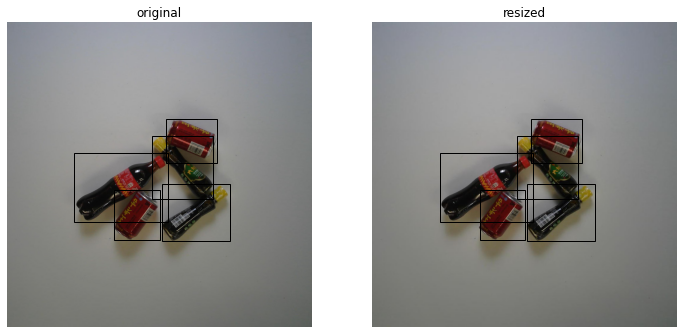

In [22]:
fig, axs = plt.subplots(ncols=2)

axs[0] = show_image(1223, train_val_images, True, train_val_annotations, ax=axs[0])
axs[0].set_title('original')

axs[1] = show_image(1223, resized_train_val_images, True, resized_train_val_annotations, ax=axs[1])
axs[1].set_title('resized')

plt.show()

Let's look at a more sizeable sample

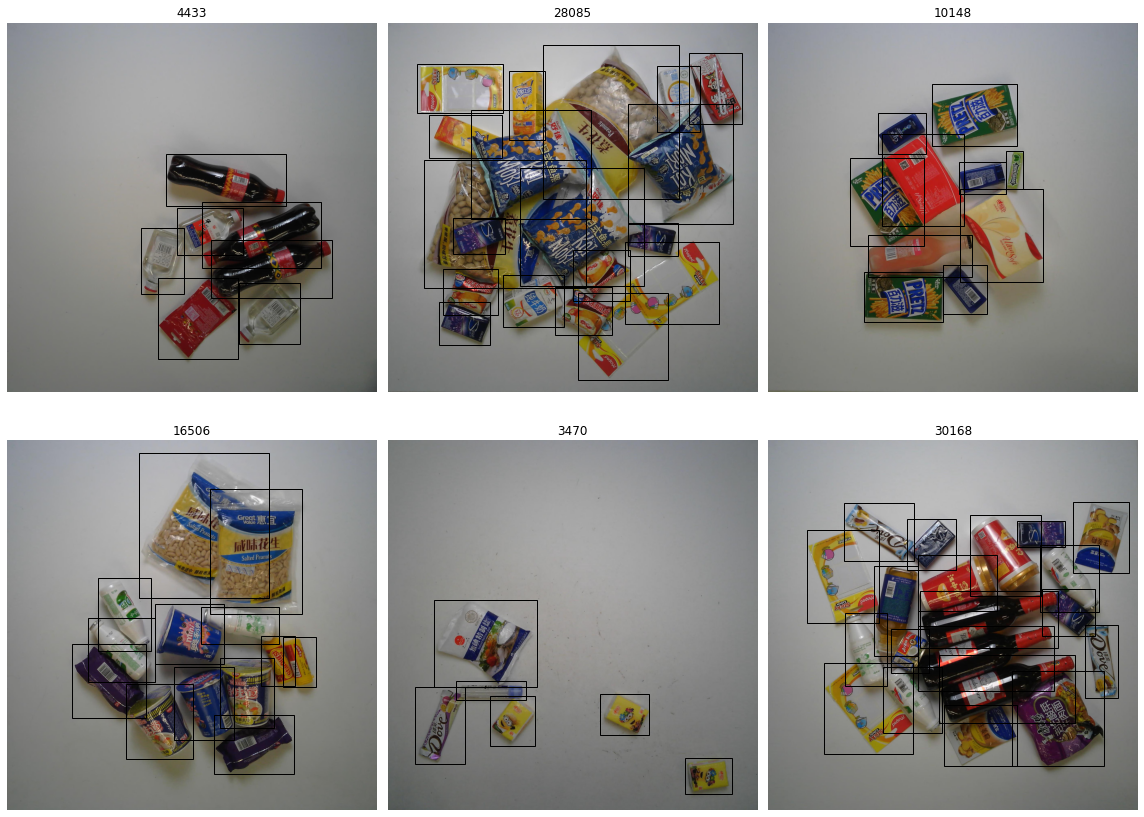

In [23]:
sample_ids = train_val_images['id'].sample(n=6, replace=False, random_state=1).values

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,12))

axs = axs.flatten()

for id, ax in zip(sample_ids, axs):
    ax = show_image(id, train_val_images, True, train_val_annotations, ax=ax)
    ax.set_title(id)

fig.tight_layout()
plt.show()
    

## Saving datasets

We should save the new dataframes to use later

In [24]:
## Dropping unnecessary columns
resized_train_val_annotations.drop(columns=['width_ratio', 'height_ratio', 'id_y'], inplace=True)
resized_train_val_annotations.rename(columns={'id_x': 'id'}, inplace=True)

In [25]:
resized_train_val_images.to_pickle('data/retail_product/resized_train_val_images.pkl')
gray_train_val_images.to_pickle('data/retail_product/gray_train_val_images.pkl')
resized_train_val_annotations.to_pickle('data/retail_product/resized_train_val_annotations.pkl')